In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils

In [2]:
seed = 2025
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(seed)
torch.set_float32_matmul_precision("high")
if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cpu


## Load Dataset

In [3]:
file_path = "../../data/MNIST_DATASET"

train_dataset = datasets.MNIST(root=file_path, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root=file_path, train=False, download=True, transform=transforms.ToTensor())

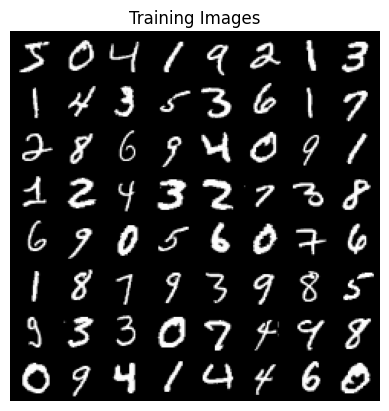

In [4]:
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(torch.cat([train_dataset[i][0].unsqueeze(0) for i in range(64)], dim=0), normalize=True), (1,2,0)))

In [5]:
image_sample, label_sample = train_dataset[0]
print(f"Image shape: {image_sample.shape}, Label: {label_sample}")

Image shape: torch.Size([1, 28, 28]), Label: 5


## Autoencoder Model

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        z = F.leaky_relu(self.fc_mean(x))
        return z


class Decoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)

    def forward(self, z: torch.Tensor):
        z = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        z = F.leaky_relu(self.fc2(z), negative_slope=0.2)
        x_hat = F.sigmoid(self.fc3(z))
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28) # b, c, h, w 변환
        return x_hat

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=Encoder, decoder=Decoder, latent_dim: int=20):

        # nn.Module의 __init__ 함수 호출
        super().__init__()
        self.encoder = encoder(latent_dim=latent_dim)
        self.decoder = decoder(latent_dim=latent_dim)
        self.latent_dim = latent_dim # 잠재 벡터

    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

In [8]:
LR = 0.001
BATCH_SIZE = 100
EPOCHS = 10
latent_dim = 20

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)
recon_loss = nn.MSELoss(reduction='sum')# loss function
optimizer = optim.Adam(params=list(autoencoder.parameters()), lr=LR)

In [10]:
history = dict(train_loss=[], valid_loss=[])
print(f"Training start with {EPOCHS} epochs.")

for epoch in range(1, 1 + EPOCHS):
    train_epoch_loss = 0
    train_size = 0

    autoencoder.train()
    for i, batch in enumerate(train_loader):
        image, label = batch
        image = image.to(device)
        train_size += label.size(0)

        latent = autoencoder.encode(image)
        reconstruction_image = autoencoder.decode(latent)

        optimizer.zero_grad()
        train_loss = recon_loss(image, reconstruction_image)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss

    test_epoch_loss = 0
    test_size = 0

    # 평가
    autoencoder.eval()
    # 추론: 그라디언트 안함
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            image, label = batch
            image = image.to(device)
            test_size += label.size(0)

            latent = autoencoder.encode(image)
            reconstruction_image = autoencoder.decode(latent)

            test_loss = recon_loss(image, reconstruction_image)
            test_epoch_loss += test_loss

    train_epoch_loss /= train_size
    test_epoch_loss /= test_size

    history["train_loss"].append(train_epoch_loss.item())
    history["valid_loss"].append(test_epoch_loss.item())

    print(
        f"[{epoch:02d}/{EPOCHS:02d}]"
        + f"Train MSE Loss = {train_epoch_loss:.4f}, "
        + f"Valid MSE Loss = {test_epoch_loss:.4f}"
    )

Training start with 10 epochs.
[01/10]Train MSE Loss = 37.9215, Valid MSE Loss = 20.8532
[02/10]Train MSE Loss = 16.8611, Valid MSE Loss = 13.3770
[03/10]Train MSE Loss = 12.1492, Valid MSE Loss = 10.6178
[04/10]Train MSE Loss = 10.2208, Valid MSE Loss = 9.3100
[05/10]Train MSE Loss = 9.1925, Valid MSE Loss = 8.6718
[06/10]Train MSE Loss = 8.5775, Valid MSE Loss = 8.2205
[07/10]Train MSE Loss = 8.1370, Valid MSE Loss = 7.8954
[08/10]Train MSE Loss = 7.8122, Valid MSE Loss = 7.6978
[09/10]Train MSE Loss = 7.5481, Valid MSE Loss = 7.4846
[10/10]Train MSE Loss = 7.2869, Valid MSE Loss = 7.1578


## Visualize

In [11]:
def visualize_loss(epochs, train_loss, valid_loss):
    x_len = np.arange(epochs)

    plt.plot(x_len, train_loss, marker=".", c="blue", label="Train Loss")
    plt.plot(x_len, valid_loss, marker=".", c="red", label="Valid Loss")
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

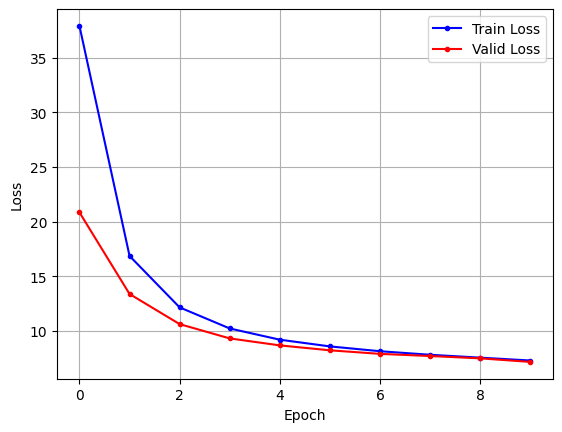

In [12]:
visualize_loss(EPOCHS, history["train_loss"], history["valid_loss"])

In [13]:
select = 0

# 평가
autoencoder.eval()
with torch.no_grad():
    # 검증용 데이터 로더에서 `select` 번째 데이터만 가져옵니다.
    for i, batch in enumerate(test_loader):
        if i != select:
            continue
        else:
            test_image, test_label = batch
            test_image = test_image.to(device)
            test_image = test_image.view(BATCH_SIZE, 1 * 28 * 28)

            z = autoencoder.encode(test_image) # 잠재 공간으로 축소
            reconstruction = autoencoder.decode(z)       # 복원
            break

데이터 배치의 첫 번째 이미지


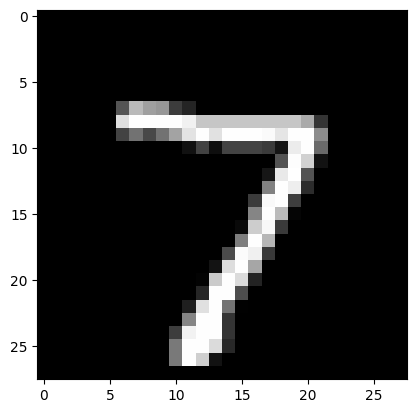

복원된 이미지


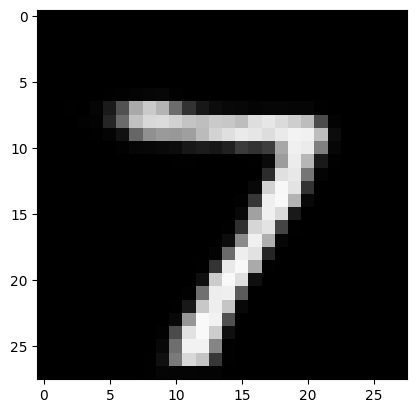

In [14]:
print("데이터 배치의 첫 번째 이미지")
plt.imshow(utils.make_grid(test_image[0].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

print("복원된 이미지")
plt.imshow(utils.make_grid(reconstruction[0].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

데이터 배치 이미지


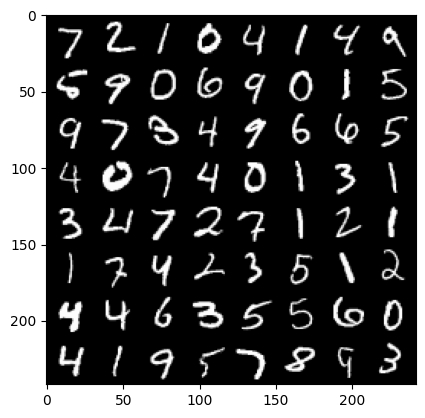

복원된 이미지


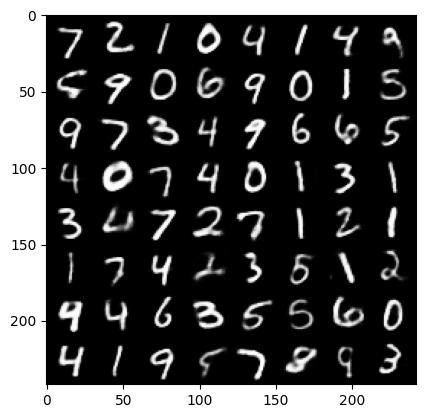

In [15]:
print("데이터 배치 이미지")
plt.imshow(utils.make_grid(test_image[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

print("복원된 이미지")
plt.imshow(utils.make_grid(reconstruction[:64].cpu()[:64].view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

In [16]:
from sklearn.manifold import TSNE

test_latents = []
test_labels = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        test_image, test_label = batch

        test_image = test_image.to(device)
        test_image = test_image.view(BATCH_SIZE, 784)

        z = autoencoder.encode(test_image)
        test_latents.append(z)
        test_labels.append(test_label)

test_latents = torch.cat(test_latents).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()

# TSNE 차원 축소
tsne = TSNE(n_components=2).fit_transform(test_latents)

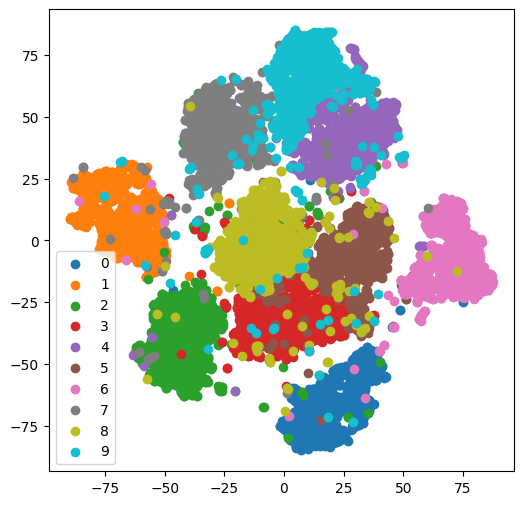

In [17]:
plt.figure(figsize=(6, 6))

# 클래스의 개수와 색 지정
target_ids = range(10)
colors = (
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
)

# TSNE를 활용하여 2차원 평면에 시각화
for i, c, label in zip(target_ids, colors, range(10)):
    plt.scatter(tsne[test_labels == i, 0], tsne[test_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [18]:
test_images = []
test_labels = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        test_image, test_label = batch
        test_image = test_image.view(BATCH_SIZE, 784)

        test_images.append(test_image)
        test_labels.append(test_label)

test_images = torch.cat(test_images).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()
tsne = TSNE(n_components=2).fit_transform(test_images)

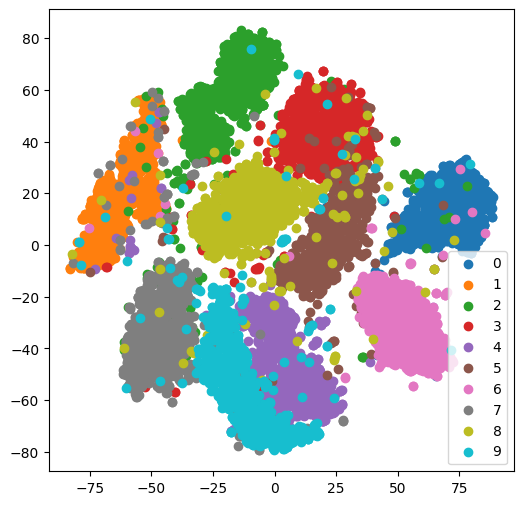

In [20]:
target_ids = range(10)

plt.figure(figsize=(6, 6))
colors = (
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
)

for i, c, label in zip(target_ids, colors, range(10)):
    plt.scatter(tsne[test_labels == i, 0], tsne[test_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

## Reference
- https://github.com/zalandoresearch/fashion-mnist